[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-XXX Orientação**
## Usando um Perceptron Multicamadas para recuperar precipitação usando o conjunto de dados de referência *IPWG Satellite Precipitation Retrieval (SPR)*

**Docente:** *Prof. Dr. Alan James Peixoto Calheiros*

**Discente:** *Lourenço José Cavalcante Neto*

---


In [7]:
# Para executar este notebook no Google Colab e/ou no Kaggle, devemos descomentar a seguinte linha para
# instalar todos os pacotes necessários:

#!pip install git+https://github.com/simonpf/at652

- Vamos considerar que já sabemos os fundamentos de rede neural e como implementá-los usando PyTorch
- Com esse conhecimento, devemos ser capazes de projetar uma recuperação de precipitação baseada em rede neural.


## Motivação

- As observações de satélite nos permitem observar a distribuição global da precipitação
- No entanto, não há relação direta entre as observações de satélite e a precipitação correspondente na superfície

![Machine learning for precipitation retrievals](../figures/retrieval.png)

## O conjunto de dados de referência IPWG ML

- O conjunto de dados de referência **IPWG Satellite Precipitation Retrieval (SPR)** foi desenvolvido pelo grupo de trabalho de aprendizado de máquina do **International Precipitation Working Group (IPWG)**
- O conjunto de dados consiste em observações de satélite colocadas junto com observações de radar terrestres sobre CONUS

<div style="text-align: center;">
  <img src="../figures/ipwgml.png" alt="Example scene from the IPWG precipitation retrieval benchmark dataset" width="800"/>
</div>

### O pacote ``ipwgml``

- O conjunto de dados pode ser acessado convenientemente por meio do pacote Python ``ipwgml``
- Documentação mais detalhada para o conjunto de dados está disponível em [ipwgml.readthedocs.org](ipwgml.readthedocs.org)
- Para instalar o pacote no ambiente atual, devemos executar

In [ ]:
# Descomentar e executar a linha a seguir se pacote ipwgml ainda não estiver instalado no ambiente:

#!pip install git+https://github.com/simonpf/ipwgml

### Obtendo e carregando os dados
- O pacote ``ipwgml`` fornece a função ``download_dataset`` para baixar os dados SPR.
- O conjunto de dados é dividido em dados de entrada consistindo em observações de diferentes sensores de sensoriamento remoto e dados de alvo correspondentes derivados de radares de precipitação baseados no solo.

In [9]:
import ipwgml
from ipwgml.data import download_dataset
import xarray as xr


# We download the validation split for now because it is smaller.
# Note that testing is performed on a completerly independent dataset.
files = download_dataset("spr", "gmi", "gmi", "validation", "on_swath", "tabular")
input_data = xr.load_dataset(files["gmi"][0], engine="h5netcdf")
target_data = xr.load_dataset(files["target"][0], engine="h5netcdf")

[01/21/25 15:32:43] INFO     INFO:numexpr.utils:NumExpr defaulting to 4 threads.                       ]8;id=848419;file:///usr/local/lib/python3.10/dist-packages/numexpr/utils.py\utils.py]8;;\:]8;id=288536;file:///usr/local/lib/python3.10/dist-packages/numexpr/utils.py#161\161]8;;\

Output()

Output()

In [10]:
files

{'target': [PosixPath('/kaggle/working/spr/gmi/validation/on_swath/tabular/target/target.nc')],
 'gmi': [PosixPath('/kaggle/working/spr/gmi/validation/on_swath/tabular/gmi/gmi.nc')]}

### Mantendo apenas estimativas de precipitação de alta qualidade

- Os dados de destino contêm um índice de qualidade de radar (variando de 0 a 1) fornecendo uma medida quantitativa da qualidade das estimativas de precipitação
- Para este exemplo, usaremos apenas amostras com um alto índice de qualidade de radar.

In [11]:
valid_samples = target_data.radar_quality_index > 0.8
input_data = input_data[{"samples": valid_samples}]
target_data = target_data[{"samples": valid_samples}]

## Análise exploratória de dados

- A análise exploratória de dados (EDA) deve ser realizada sempre que você estiver trabalhando com um novo conjunto de dados.
- O conjunto de dados determina o que seu modelo aprende, então é crucial entender suas propriedades.
- A EDA adequada também ajudará você com problemas de dados que podem fazer com que seu treinamento falhe.
- Coisas a serem observadas:
- Valores NAN: eles precisam ser substituídos para treinamento
- Valores mínimos e máximos suspeitos, como -9999, que podem ser um sinalizador para valores ausentes.
- Valores não físicos, como taxas de precipitação negativas.

### Dados de entrada

In [12]:
import pandas as pd

channel_stats = []
for channel in range(input_data.channel.size):
    channel_data = input_data.observations[{"channel": channel}].to_dataframe()
    channel_data = channel_data.rename({"observations": f"Channel {channel + 1}"}, axis=1)
    channel_stats.append(channel_data)
    
pd.concat(channel_stats, axis=1).describe()

,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Channel 13
count,3.258979e+06,3.258974e+06,3.258747e+06,3.258552e+06,3.258987e+06,3.258987e+06,3.258987e+06,3.258987e+06,3.258987e+06,2.678759e+06,2.678759e+06,2.678759e+06,2.678759e+06
mean,2.609613e+02,2.441096e+02,2.650483e+02,2.514391e+02,2.679727e+02,2.665856e+02,2.549959e+02,2.708065e+02,2.640270e+02,2.721501e+02,2.704423e+02,2.582835e+02,2.674665e+02
std,3.036579e+01,4.813712e+01,2.555046e+01,4.193598e+01,2.042495e+01,2.066952e+01,3.556570e+01,1.679146e+01,2.342350e+01,1.450469e+01,1.637944e+01,8.247438e+00,1.036605e+01
min,1.561100e+02,7.953000e+01,1.711700e+02,9.000000e+01,1.541800e+02,1.038100e+02,1.020800e+02,6.156000e+01,6.011000e+01,6.926000e+01,6.704000e+01,7.259000e+01,7.092000e+01
25%,2.585500e+02,2.443200e+02,2.610000e+02,2.502700e+02,2.620500e+02,2.616000e+02,2.528400e+02,2.644900e+02,2.577700e+02,2.673700e+02,2.653400e+02,2.531600e+02,2.631000e+02
50%,2.682600e+02,2.590100e+02,2.709600e+02,2.641900e+02,2.720900e+02,2.713400e+02,2.659800e+02,2.737400e+02,2.699000e+02,2.751000e+02,2.743000e+02,2.579400e+02,2.682800e+02
75%,2.782700e+02,2.704100e+02,2.801200e+02,2.746400e+02,2.810000e+02,2.796100e+02,2.753300e+02,2.817700e+02,2.792300e+02,2.809100e+02,2.806100e+02,2.633300e+02,2.733000e+02
max,3.479400e+02,3.497600e+02,3.498700e+02,3.499700e+02,3.141500e+02,3.179700e+02,3.060000e+02,3.130600e+02,3.084300e+02,3.093700e+02,3.061900e+02,2.855100e+02,2.984900e+02


### Dados de saída

In [13]:
target_data.surface_precip.to_dataframe().head(n=10)

,surface_precip
samples,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0


In [14]:
target_data.surface_precip.to_dataframe().describe()

,surface_precip
count,3.258987e+06
mean,1.011049e-01
std,9.690891e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.077300e+02


### Correlações

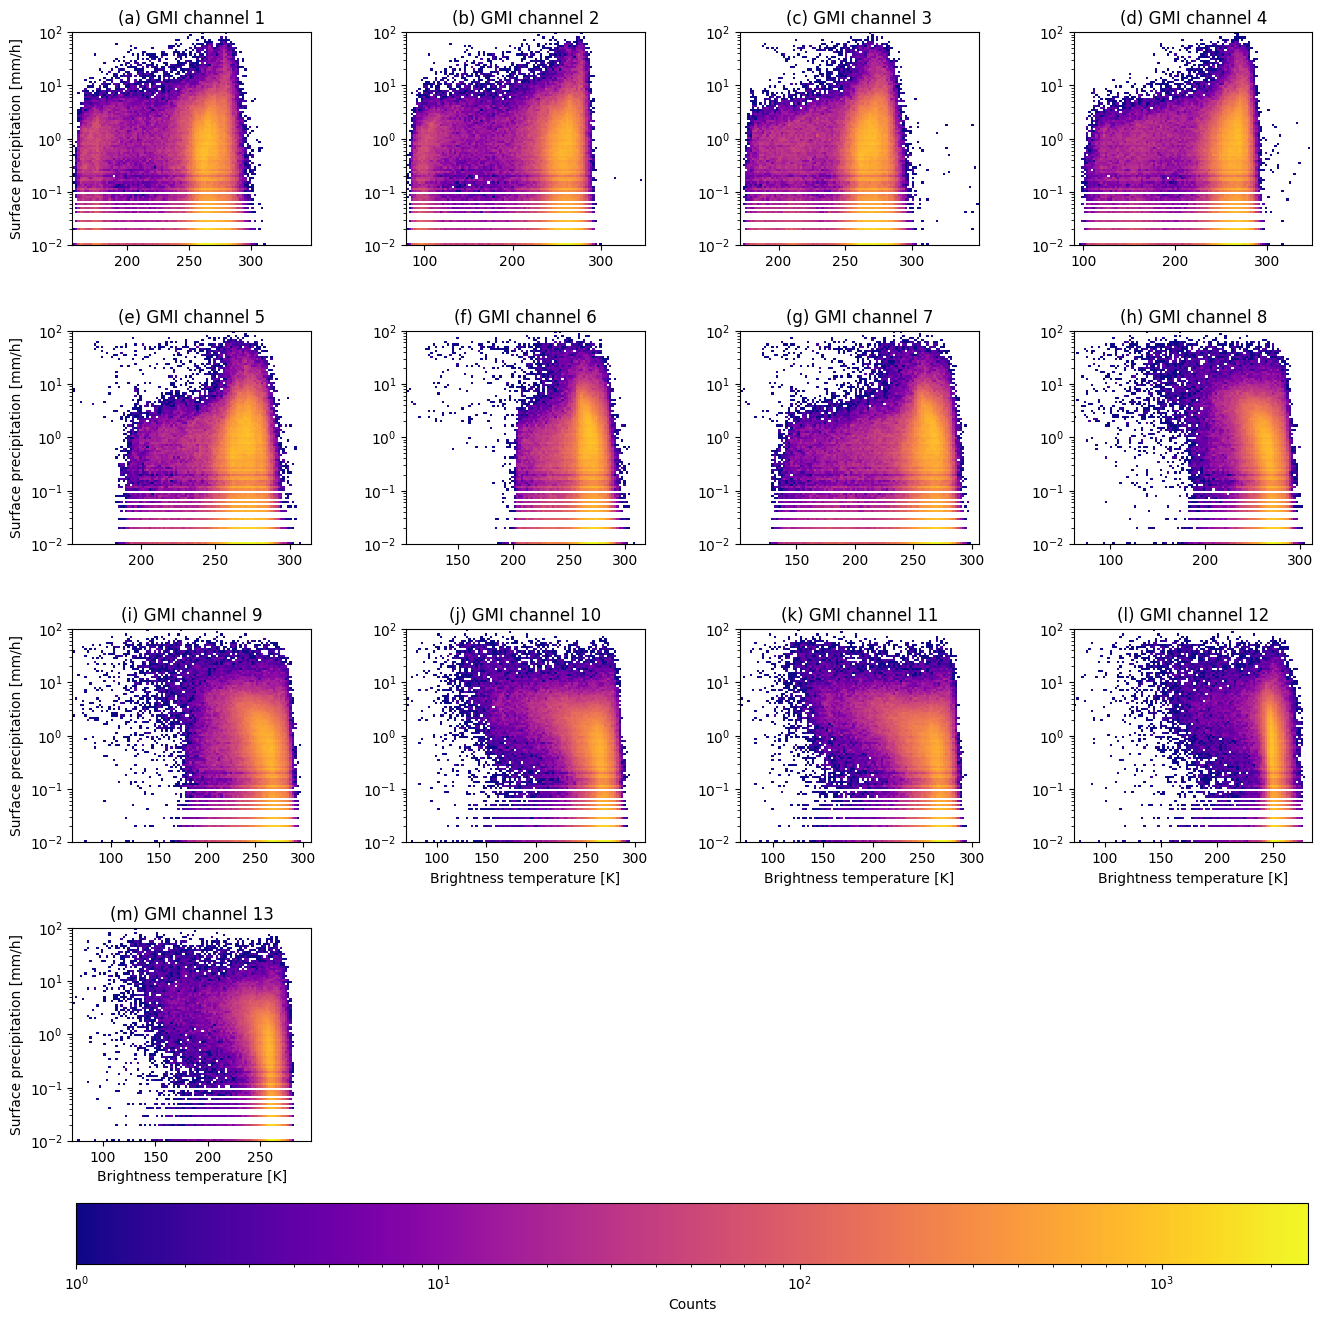

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import numpy as np

# Número de linhas e colunas na grade
n_rows, n_cols = 4, 4
max_channels = 13  # Número máximo de canais a serem exibidos

# Criar figura com melhor proporção
fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))
gs = GridSpec(n_rows, n_cols, wspace=0.4, hspace=0.4)

# Dados dos bins (realizados uma vez)
surface_precip = target_data["surface_precip"].data
surface_precip_bins = np.logspace(-2, 2, 101)

for channel_ind in range(max_channels):
    # Definir índice de linha e coluna baseado no canal
    row_ind, col_ind = divmod(channel_ind, n_cols)
    
    # Dados específicos do canal
    obs = input_data["observations"][{"channel": channel_ind}]
    obs_bins = np.linspace(obs.min(), obs.max(), 101)
    cts = np.histogram2d(obs, surface_precip, bins=(obs_bins, surface_precip_bins))[0]

    # Criar subplot apenas quando necessário
    ax = fig.add_subplot(gs[row_ind, col_ind])
    pcm = ax.pcolormesh(
        obs_bins,
        surface_precip_bins,
        cts.T,
        norm=LogNorm(vmin=1, vmax=cts.max()),  # Evitar valores invisíveis
        cmap="plasma"
    )
    
    # Configurações do eixo
    ax.set_yscale("log")
    ax.set_title(f"({chr(ord('a') + channel_ind)}) GMI channel {channel_ind + 1}")

    # Eixos personalizados
    if col_ind == 0:
        ax.set_ylabel("Surface precipitation [mm/h]")
    if row_ind == n_rows - 1 or channel_ind >= max_channels - n_cols:
        ax.set_xlabel("Brightness temperature [K]")

# Barra de cores geral para toda a figura
cbar = fig.colorbar(pcm, ax=fig.axes, orientation="horizontal", fraction=0.05, pad=0.05)
cbar.set_label("Counts")

plt.show()


## Treinando uma recuperação de rede neural simples

- Abaixo, usaremos as técnicas que aprendemos para treinar uma rede neural totalmente conectada muito básica para recuperar precipitação de superfície

### Preparando os dados

- É comum normalizar os dados de entrada para redes neurais. Abaixo, usamos a normalização min-max para mapear todos os recursos de entrada para o intervalo [-1, 1]
- Redes neurais não conseguem lidar com valores NAN. Então, nós os substituímos por -1.5 (menos um ponto cinco)
- Também convertemos todos os dados de entrada para torch.Tensors e tipos de ponto flutuante de 32 bits.

In [16]:
import torch 

obs_min = input_data.observations.min("samples")
obs_max = input_data.observations.max("samples")

obs_n = -1.0  + (input_data.observations - obs_min) / (obs_max - obs_min)
obs = torch.tensor(obs_n.data).to(torch.float32)
obs = torch.nan_to_num(obs, nan=-1.5)

obs = torch.tensor(obs.data).to(torch.float32)
surface_precip = torch.tensor(target_data.surface_precip.data).to(torch.float32)

<ipython-input-16-35804dea9d2b>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs.data).to(torch.float32)


#### Conjuntos de dados de treinamento e validação

- Desta vez, dividimos os dados em conjuntos de dados de treinamento e validação para que possamos usar o conjunto de dados de validação para monitorar o progresso do treinamento.

In [17]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(
    obs.reshape(-1, 13),
    surface_precip.reshape(-1, 1)
)
training_data, validation_data = random_split(dataset, (0.8, 0.2))
training_loader = DataLoader(training_data, num_workers=4, batch_size=1024, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=4, batch_size=1024, shuffle=True)

### A rede neural

- Usamos uma rede neural semelhante à anterior, mas ajustamos o número de recursos de entrada para corresponder ao número de canais do sensor GMI.

In [18]:
from torch import nn

mlp = nn.Sequential(
    nn.Linear(13, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

### Treinamento


In [19]:
from tqdm import tqdm
from torch.optim import SGD

loss_fn = nn.MSELoss()
optimizer = SGD(mlp.parameters(), lr=5e-2)

n_epochs = 5

for epoch_index in range(n_epochs):

    tot_loss = 0.0
    n_samples = 0
    
    for x_b, y_b in tqdm(training_loader):
        
        loss = loss_fn(y_b, mlp(x_b))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    val_loss = 0
    for x_b, y_b in validation_loader:
        with torch.no_grad():
            y_pred = mlp(x_b)
            val_loss += loss_fn(y_b, y_pred).item()

    print(f"Epoch {epoch_index}, Validation loss: {val_loss / len(validation_loader)}")


100%|██████████| 2547/2547 [00:23<00:00, 107.92it/s]


Epoch 0, Validation loss: 0.9401352551752582


100%|██████████| 2547/2547 [00:23<00:00, 110.22it/s]


Epoch 1, Validation loss: 0.8113084515115155


100%|██████████| 2547/2547 [00:23<00:00, 110.09it/s]


Epoch 2, Validation loss: 0.7075414819002526


100%|██████████| 2547/2547 [00:23<00:00, 108.92it/s]


Epoch 3, Validation loss: 0.8585307192601251


100%|██████████| 2547/2547 [00:23<00:00, 108.86it/s]


Epoch 4, Validation loss: 0.6535835061310038


## Resultados

- O pacote ``ipwgml`` fornece funcionalidade interna para avaliar qualquer recuperação de precipitação de ML.
- Para isso, precisamos definir apenas um objeto de retorno de chamada que execute nossa recuperação de NN em dados de entrada fornecidos

In [20]:
class RetrievalCallback:
    """
    A callable that run the given PyTorch model on IPWGML
    retrieval test data.
    """
    def __init__(self, model: nn.Module):
        """
        Args:
            model: The trained PyTorch model implemented the retrieval.
        """
        self.model = model.eval()
        
    def __call__(self, input_data: xr.Dataset) -> xr.Dataset:
    
        input_data = input_data.transpose("batch", "channels_gmi")

        # Don't forget to normalize your input data in the exact same
        # way during inference as during training
        obs = input_data.obs_gmi.data
        obs_n = -1.0 +(obs - obs_min.data) / (obs_max.data - obs_min.data)
        obs = torch.nan_to_num(torch.tensor(obs_n).to(torch.float32), nan=-1.5)

        with torch.no_grad():
            surface_precip = self.model(obs)
    
        return xr.Dataset({
            "surface_precip": (("samples",), surface_precip[..., 0])
        })

### Estudo de caso

Output()

Output()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


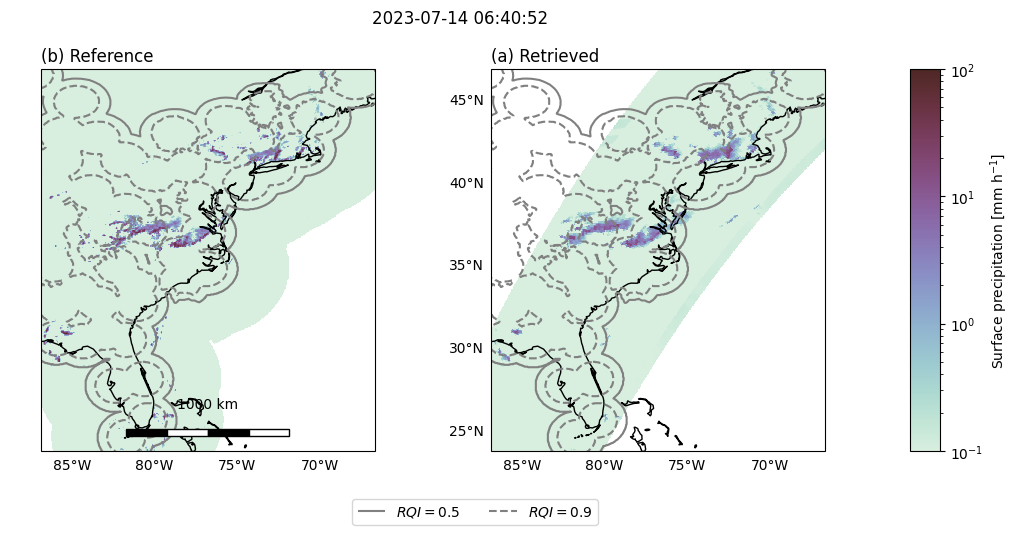

In [21]:
from ipwgml.evaluation import Evaluator

retrieval_fn = RetrievalCallback(mlp)
evaluator = Evaluator(
    domain="conus",
    reference_sensor="gmi",
    geometry="on_swath",
    retrieval_input=["gmi"],
)
evaluator.plot_retrieval_results(
    scene_index=86,
    retrieval_fn=retrieval_fn,
    input_data_format="tabular",
    batch_size=1024
);

### Métricas de recuperação

- O ``evaluate`` executa a recuperação em todas as cenas no conjunto de dados de teste e avalia os resultados usando várias métricas

In [22]:
evaluator.evaluate(
    retrieval_fn=retrieval_fn, 
    input_data_format="tabular",
)

Output()

In [23]:
baseline_results = evaluator.get_precip_quantification_results(name="Simple NN")
baseline_results

,Bias [$\%$],MAE [$mm h^{-1}$],MSE [$(mm h^{-1})^2$],SMAPE$_{0.1}$ [$\%$],Correlation coeff. [],Effective resolution [$^\circ$]
Simple NN,-35.593497,0.136453,1.844128,114.876591,0.494265,inf
IMERG Final V7 (GMI),-7.398772,0.124924,1.731411,114.417614,0.455411,inf
GPROF V7 (GMI),5.799770,0.119785,1.413339,91.327371,0.552348,0.423


## Exercício

- Tentar melhorar o desempenho do Simple NN acima.
- Coisas que podemos querer tentar:
- Usar a divisão de treinamento do conjunto de dados SPR
- Treinar com mais épocas
- Reduzir a taxa de aprendizado em direção ao final do treinamento
- Usar um otimizador diferente
- Tentar cronogramas de taxa de aprendizado
- Usar um modelo mais profundo
- Usar um modelo mais amplo